### Initialize and collect ohlcv data

In [15]:
import datetime
import time
import pandas as pd
from binance.client import Client
from binance.enums import HistoricalKlinesType

# input parameters
symbol = 'ETCUSDT'
interval = '1h'


def collect_historical_price(client, symbol='ETHUSDT', interval='15m'):
    ########## READING HISTORIC PRICE AND ADDING INDICATORS##########

    df_his = pd.DataFrame(
        client.get_historical_klines(symbol, interval, klines_type=HistoricalKlinesType.FUTURES))
    df_his = df_his.drop(columns=[6, 7, 8, 9, 10, 11])
    df_his.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    # converting unix to datetime
    df_his['Date'] = pd.to_numeric(df_his['Date'])
    df_his['Date'] = df_his['Date'] / 1000
    for i in range(len(df_his.index)):
        df_his['Date'][i] = datetime.datetime.fromtimestamp(df_his['Date'][i])
    # converting str to int
    df_his['Open'] = pd.to_numeric(df_his['Open'])
    df_his['High'] = pd.to_numeric(df_his['High'])
    df_his['Low'] = pd.to_numeric(df_his['Low'])
    df_his['Close'] = pd.to_numeric(df_his['Close'])
    df_his['Volume'] = pd.to_numeric(df_his['Volume'])
    df_his.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    return df_his


########## INITIALIZING ##########

api_key = 'qnWZgAfFaeofQLVCysgdcG2tjKuD7aDzCuk7IHT7hHRAWy9vQXQsVsotPup43M7N'
api_secret = 'zpqxPiAFtTIrsnoOQn8dlldeFgCb5XEe7vaA0FO0hVxeu0eGWOyECghwEFwQXvGw' 
client = Client(api_key, api_secret, testnet=False)
client.API_URL = 'https://api1.binance.com' 
try:
    df = collect_historical_price(client=client, symbol=symbol, interval=interval)
except Exception:
    print('THERE IS SOMETHING WRONG WITH API......')
df.tail()


/var/folders/1t/61wtfz9d3gqc_xpjp16ypt440000gn/T/ipykernel_17848/2726526741.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_his['Date'][i] = datetime.datetime.fromtimestamp(df_his['Date'][i])


,date,open,high,low,close,volume
995,2022-09-09 15:00:00,38.987,39.009,38.500,38.648,1559239.70
996,2022-09-09 16:00:00,38.648,39.223,38.564,38.803,2215657.87
997,2022-09-09 17:00:00,38.805,38.827,38.326,38.776,1718392.59
998,2022-09-09 18:00:00,38.775,39.100,38.604,38.863,1562061.23
999,2022-09-09 19:00:00,38.863,38.921,38.470,38.720,1021648.59


### Indicators

In [16]:
import numpy as np

def concat(df1, list1):
    list1 = pd.DataFrame(list1).T
    list1.columns = ['Start', 'End', 'Ratio']
    return pd.concat([df1, list1], axis=0, ignore_index=True)

def ATR(DF, period=14):
    df = DF.copy()
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1, skipna=False)
    df['ATR'] = df['TR'].ewm(span=period, min_periods=period).mean()
    return df['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(365*24)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

a = 40
b = 47
c = 13
df['ATR'] = ATR(df, period=c)
df['5ema'] = df['close'].ewm(com=a, min_periods=a).mean()
df['20ema'] = df['close'].ewm(com=b, min_periods=b).mean()

df

,date,open,high,low,close,volume,ATR,5ema,20ema
0,2022-07-30 04:00:00,39.297,40.750,38.946,40.321,3529389.85,NaN,NaN,NaN
1,2022-07-30 05:00:00,40.320,40.493,39.118,39.775,1598232.95,NaN,NaN,NaN
2,2022-07-30 06:00:00,39.775,41.814,39.712,41.463,2956659.89,NaN,NaN,NaN
3,2022-07-30 07:00:00,41.463,42.398,40.245,40.458,4713761.48,NaN,NaN,NaN
4,2022-07-30 08:00:00,40.458,41.243,39.545,40.363,4523137.78,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,2022-09-09 15:00:00,38.987,39.009,38.500,38.648,1559239.70,0.827197,36.447033,36.256199
996,2022-09-09 16:00:00,38.648,39.223,38.564,38.803,2215657.87,0.803169,36.504496,36.309257
997,2022-09-09 17:00:00,38.805,38.827,38.326,38.776,1718392.59,0.760002,36.559898,36.360648
998,2022-09-09 18:00:00,38.775,39.100,38.604,38.863,1562061.23,0.722287,36.616072,36.412780


### Backtesting

In [17]:
ret = []
signal = ''
transaction = pd.DataFrame([1,1,1]).T
transaction.columns = ['Start', 'End', 'Ratio']
trans = []
start_price = 0

for i in range(len(df)):

    if signal == '':
        ret.append(0)
        if df['5ema'][i]>df['20ema'][i]:
            signal = 'BUY'
            stop_loss_atr = df['close'][i] - df['ATR'][i]
            stop_profit_atr = df['close'][i] + 2 * df['ATR'][i]

            # Don't touch
            trans.append(df['date'][i])
            start_price = df['close'][i]

        elif df['5ema'][i]<df['20ema'][i]:
            signal = 'SELL'
            stop_loss_atr = df['close'][i] + df['ATR'][i]
            stop_profit_atr = df['close'][i] - 2 * df['ATR'][i]

            # Don't touch
            trans.append(df['date'][i])
            start_price = df['close'][i]
    
    elif signal == 'BUY':
        if df['close'][i]>stop_profit_atr:  # stop profit
            signal = ''

            # Don't touch
            ret.append((df['close'][i]/df['close'][i-1])-1)
            trans.append(df['date'][i])
            trans.append((df['close'][i] - start_price)/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0

        elif df['close'][i]<stop_loss_atr: # stop loss
            signal = ''

            # Don't touch
            ret.append((df['close'][i]/df['close'][i-1])-1)
            trans.append(df['date'][i])
            trans.append((df['close'][i] - start_price)/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0

        else:
            # Don't touch
            ret.append((df['close'][i]/df['close'][i-1])-1)
    
    elif signal == 'SELL':
        if df['close'][i]<stop_profit_atr:  # normal stop profit
            signal = ''

            # Don't touch
            ret.append((df['close'][i-1]/df['close'][i])-1)
            trans.append(df['date'][i])
            trans.append((start_price - df['close'][i])/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0

        elif stop_loss_atr>df['close'][i]:  # stop loss
            signal = ''

            # Don't touch
            ret.append((df['close'][i-1]/df['close'][i])-1)
            trans.append(df['date'][i])
            trans.append((df['close'][i] - start_price)/start_price)
            transaction = concat(transaction, trans)
            trans = []
            start_price = 0

        else:
            # Don't touch
            ret.append((df['close'][i-1]/df['close'][i])-1)

# Don't touch
transaction['Ratio'] = 100 * transaction['Ratio']
transaction = transaction.drop([0])
sum = transaction['Ratio'].sum()

# Total profit ratio and KPIs
ret = pd.DataFrame(ret, columns=['ret'])
winrate = transaction['Ratio'][transaction['Ratio']>0].count() / len(transaction)
print('Profit ratio(%):',sum)
print('Win rate(%):', winrate*100)
print('CAGR:',CAGR(ret))
print('Sharpe ratio:', sharpe(ret, 0.0343))
print('Max drawdown:', max_dd(ret))

Profit ratio(%): -12.845743815872378
Win rate(%): 47.767857142857146
CAGR: -0.036905216977201616
Sharpe ratio: -0.04825517144074516
Max drawdown: 0.2746189017475013


### Plotting

<AxesSubplot:>

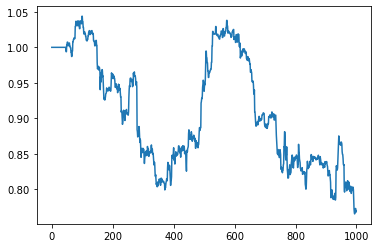

In [14]:
(1+ret["ret"]).cumprod().plot()

In [97]:
ret

,ret
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
995,0.003360
996,-0.000300
997,0.001668
998,0.002706
